<div class="markdown-google-sans">

# <strong>Bayesian Statistics `Logit`</strong>
> #### Gabriel L. S. Silva
</div>

In [3]:
!pip install ucimlrepo --quiet

In [39]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings

import arviz as az
import pymc as pm

plt.style.use('bmh')
warnings.filterwarnings('ignore')

In [48]:
raw = fetch_ucirepo(id=17)
df = raw.data.features
df['target'] = raw.data.targets
df['target'] = df['target'].apply(lambda x: 1 if x == 'M' else 0)
df.sample(3)

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3,target
543,13.21,28.06,84.88,538.4,0.08671,0.06877,0.02987,0.03275,0.1628,0.05781,...,37.17,92.48,629.6,0.1072,0.1381,0.1062,0.07958,0.2473,0.06443,0
255,13.96,17.05,91.43,602.4,0.10960,0.12790,0.09789,0.05246,0.1908,0.06130,...,22.07,108.10,826.0,0.1512,0.3262,0.3209,0.13740,0.3068,0.07957,1
461,27.42,26.27,186.90,2501.0,0.10840,0.19880,0.36350,0.16890,0.2061,0.05623,...,31.37,251.20,4254.0,0.1357,0.4256,0.6833,0.26250,0.2641,0.07427,1


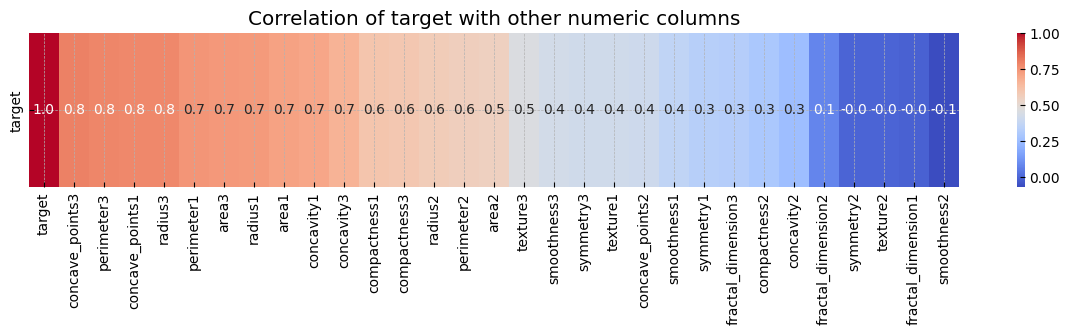

In [49]:
cr = df.corr(numeric_only=True)[['target']].sort_values('target', ascending=0)

plt.figure(figsize=(15, 2))
sns.heatmap(cr.T, annot=True, cmap='coolwarm', fmt='.1f')
plt.title('Correlation of target with other numeric columns')
plt.show()

### Descarte
> Selecionarei somente as variáveis que tem baixa correlação com a `target`, sem repetir informação. Veja quais são elas abaixo:

In [50]:
features = cr[cr['target'] < .5].index
display(features)

Index(['texture3', 'smoothness3', 'symmetry3', 'texture1', 'concave_points2',
       'smoothness1', 'symmetry1', 'fractal_dimension3', 'compactness2',
       'concavity2', 'fractal_dimension2', 'symmetry2', 'texture2',
       'fractal_dimension1', 'smoothness2'],
      dtype='object')

#### Treino e Teste
> Separo um conjunto de treino e teste, estratificado pelo `target` para que a amostra seja bem dividia e diminua o vies

In [51]:
all_features = df.drop('target', axis=1).columns
df[all_features] = df[all_features].apply(lambda x: (x-x.mean())/x.std())

X_train, X_test, y_train, y_test = train_test_split(df[features], df['target'], test_size=0.3, random_state=42, stratify=df['target'])

### **Criação do Modelo**
> Regressão Logistica

In [54]:
coords = {'features': features}

In [61]:
with pm.Model(coords=coords) as logit_model:
  alpha = pm.Normal('alpha', 0, 1)
  betas = pm.Normal('betas', 0, 1, dims='features')

  X = pm.Data('X', X_train)
  y = pm.Data('y', y_train)

  mu = alpha + pm.math.dot(X, betas)
  likelihood = pm.Bernoulli('likelihood', pm.math.sigmoid(mu), observed=y)

In [62]:
with logit_model: # Analise a priore
  trace_prior = pm.sample_prior_predictive()

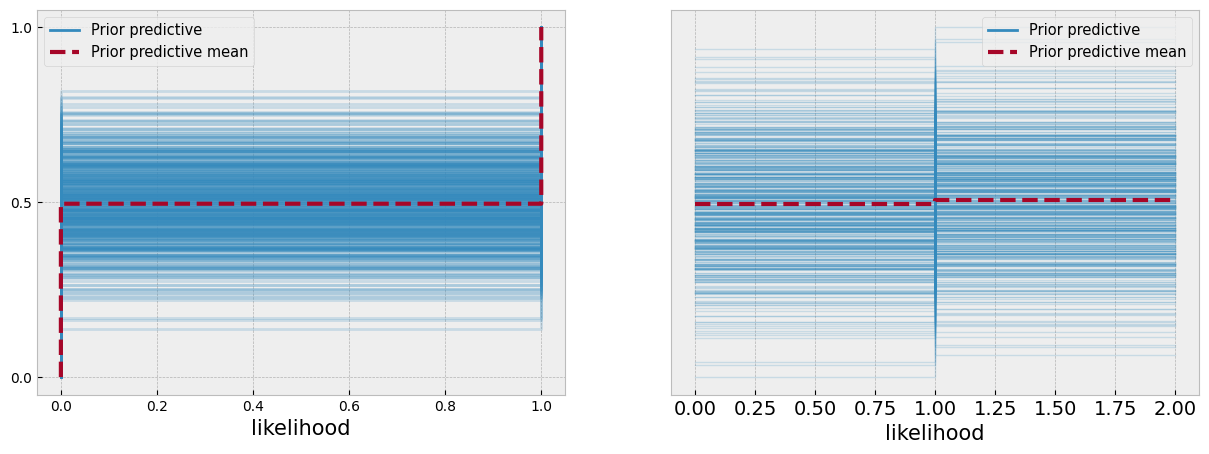

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
az.plot_ppc(trace_prior, group='prior', kind='cumulative', ax=axes[0])
az.plot_ppc(trace_prior, group='prior', ax=axes[1]);

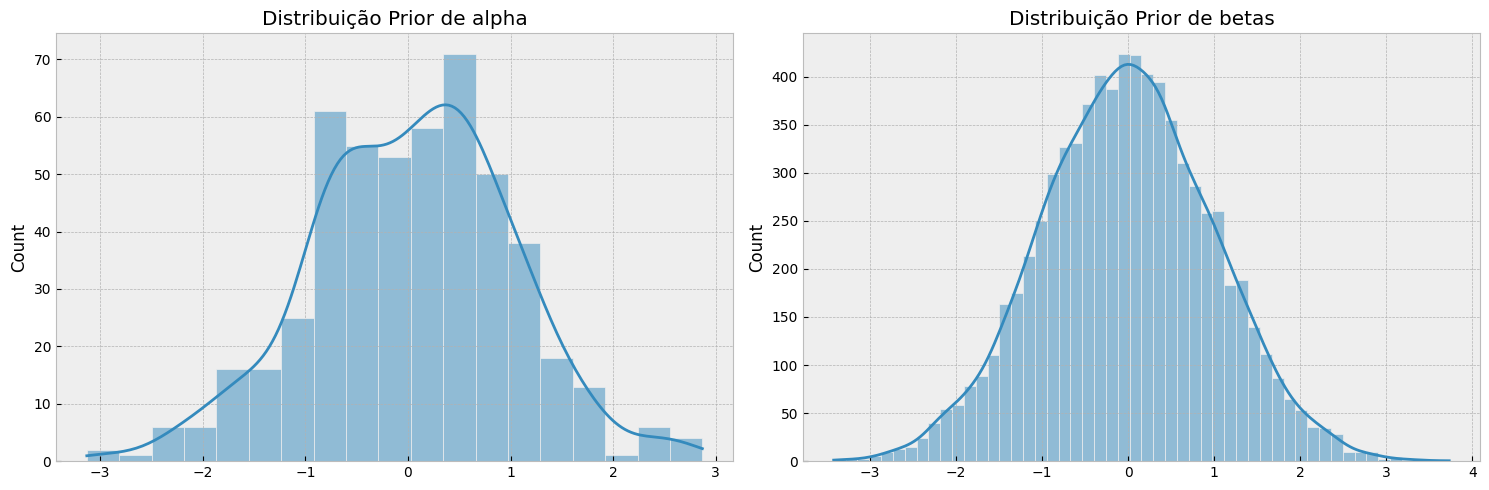

In [64]:
# Aqui temos a distribuição dos parâmetros
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for i, param in enumerate(['alpha', 'betas']):
  sns.histplot(trace_prior.prior[param].values.flatten(), kde=True, ax=axes[i])
  axes[i].set_title(f'Distribuição Prior de {param}')

plt.tight_layout(); plt.show()

Antes de levar em conta os dados observados no `pm.sample()`, temos aqui uma breve análise a prior do model, usando a média preditiva a prior e a distribuição dos parametros

In [65]:
with logit_model: trace=pm.sample()
pm.summary(trace)

Output()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-1.503,0.220,-1.909,-1.084,0.005,0.003,2230.0,1541.0,1.0
betas[texture3],1.077,0.558,0.073,2.162,0.015,0.012,1310.0,1162.0,1.0
betas[smoothness3],0.260,0.464,-0.656,1.091,0.014,0.010,1168.0,1544.0,1.0
betas[symmetry3],0.941,0.408,0.144,1.668,0.012,0.008,1241.0,1439.0,1.0
betas[texture1],0.502,0.447,-0.323,1.360,0.012,0.009,1309.0,1163.0,1.0
betas[concave_points2],1.901,0.359,1.248,2.596,0.008,0.006,2069.0,1509.0,1.0
betas[smoothness1],1.965,0.430,1.154,2.738,0.012,0.009,1340.0,1323.0,1.0
betas[symmetry1],-0.027,0.331,-0.616,0.628,0.008,0.007,1934.0,1458.0,1.0
betas[fractal_dimension3],1.138,0.488,0.226,2.070,0.013,0.009,1432.0,1332.0,1.0
betas[compactness2],0.452,0.402,-0.316,1.205,0.009,0.008,1842.0,1240.0,1.0


> Pela análise de todos os betas, temos que o modelo teve uma boa convergência dos dados, pelo valor do `r_hat` sendo 1. Podemos ver isso visualmente abaixo

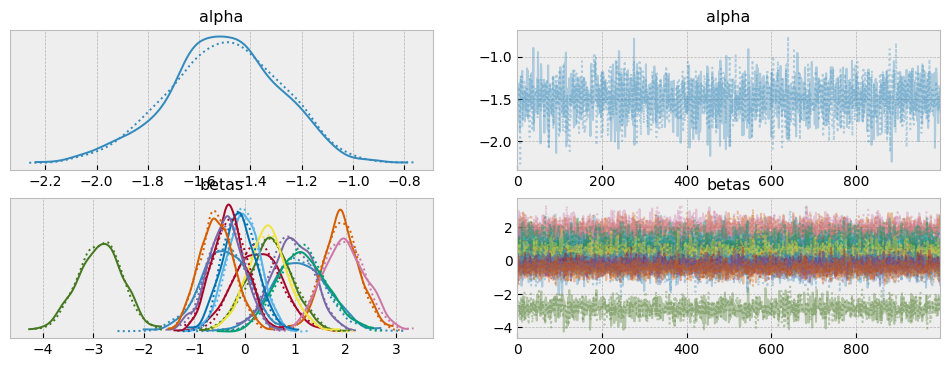

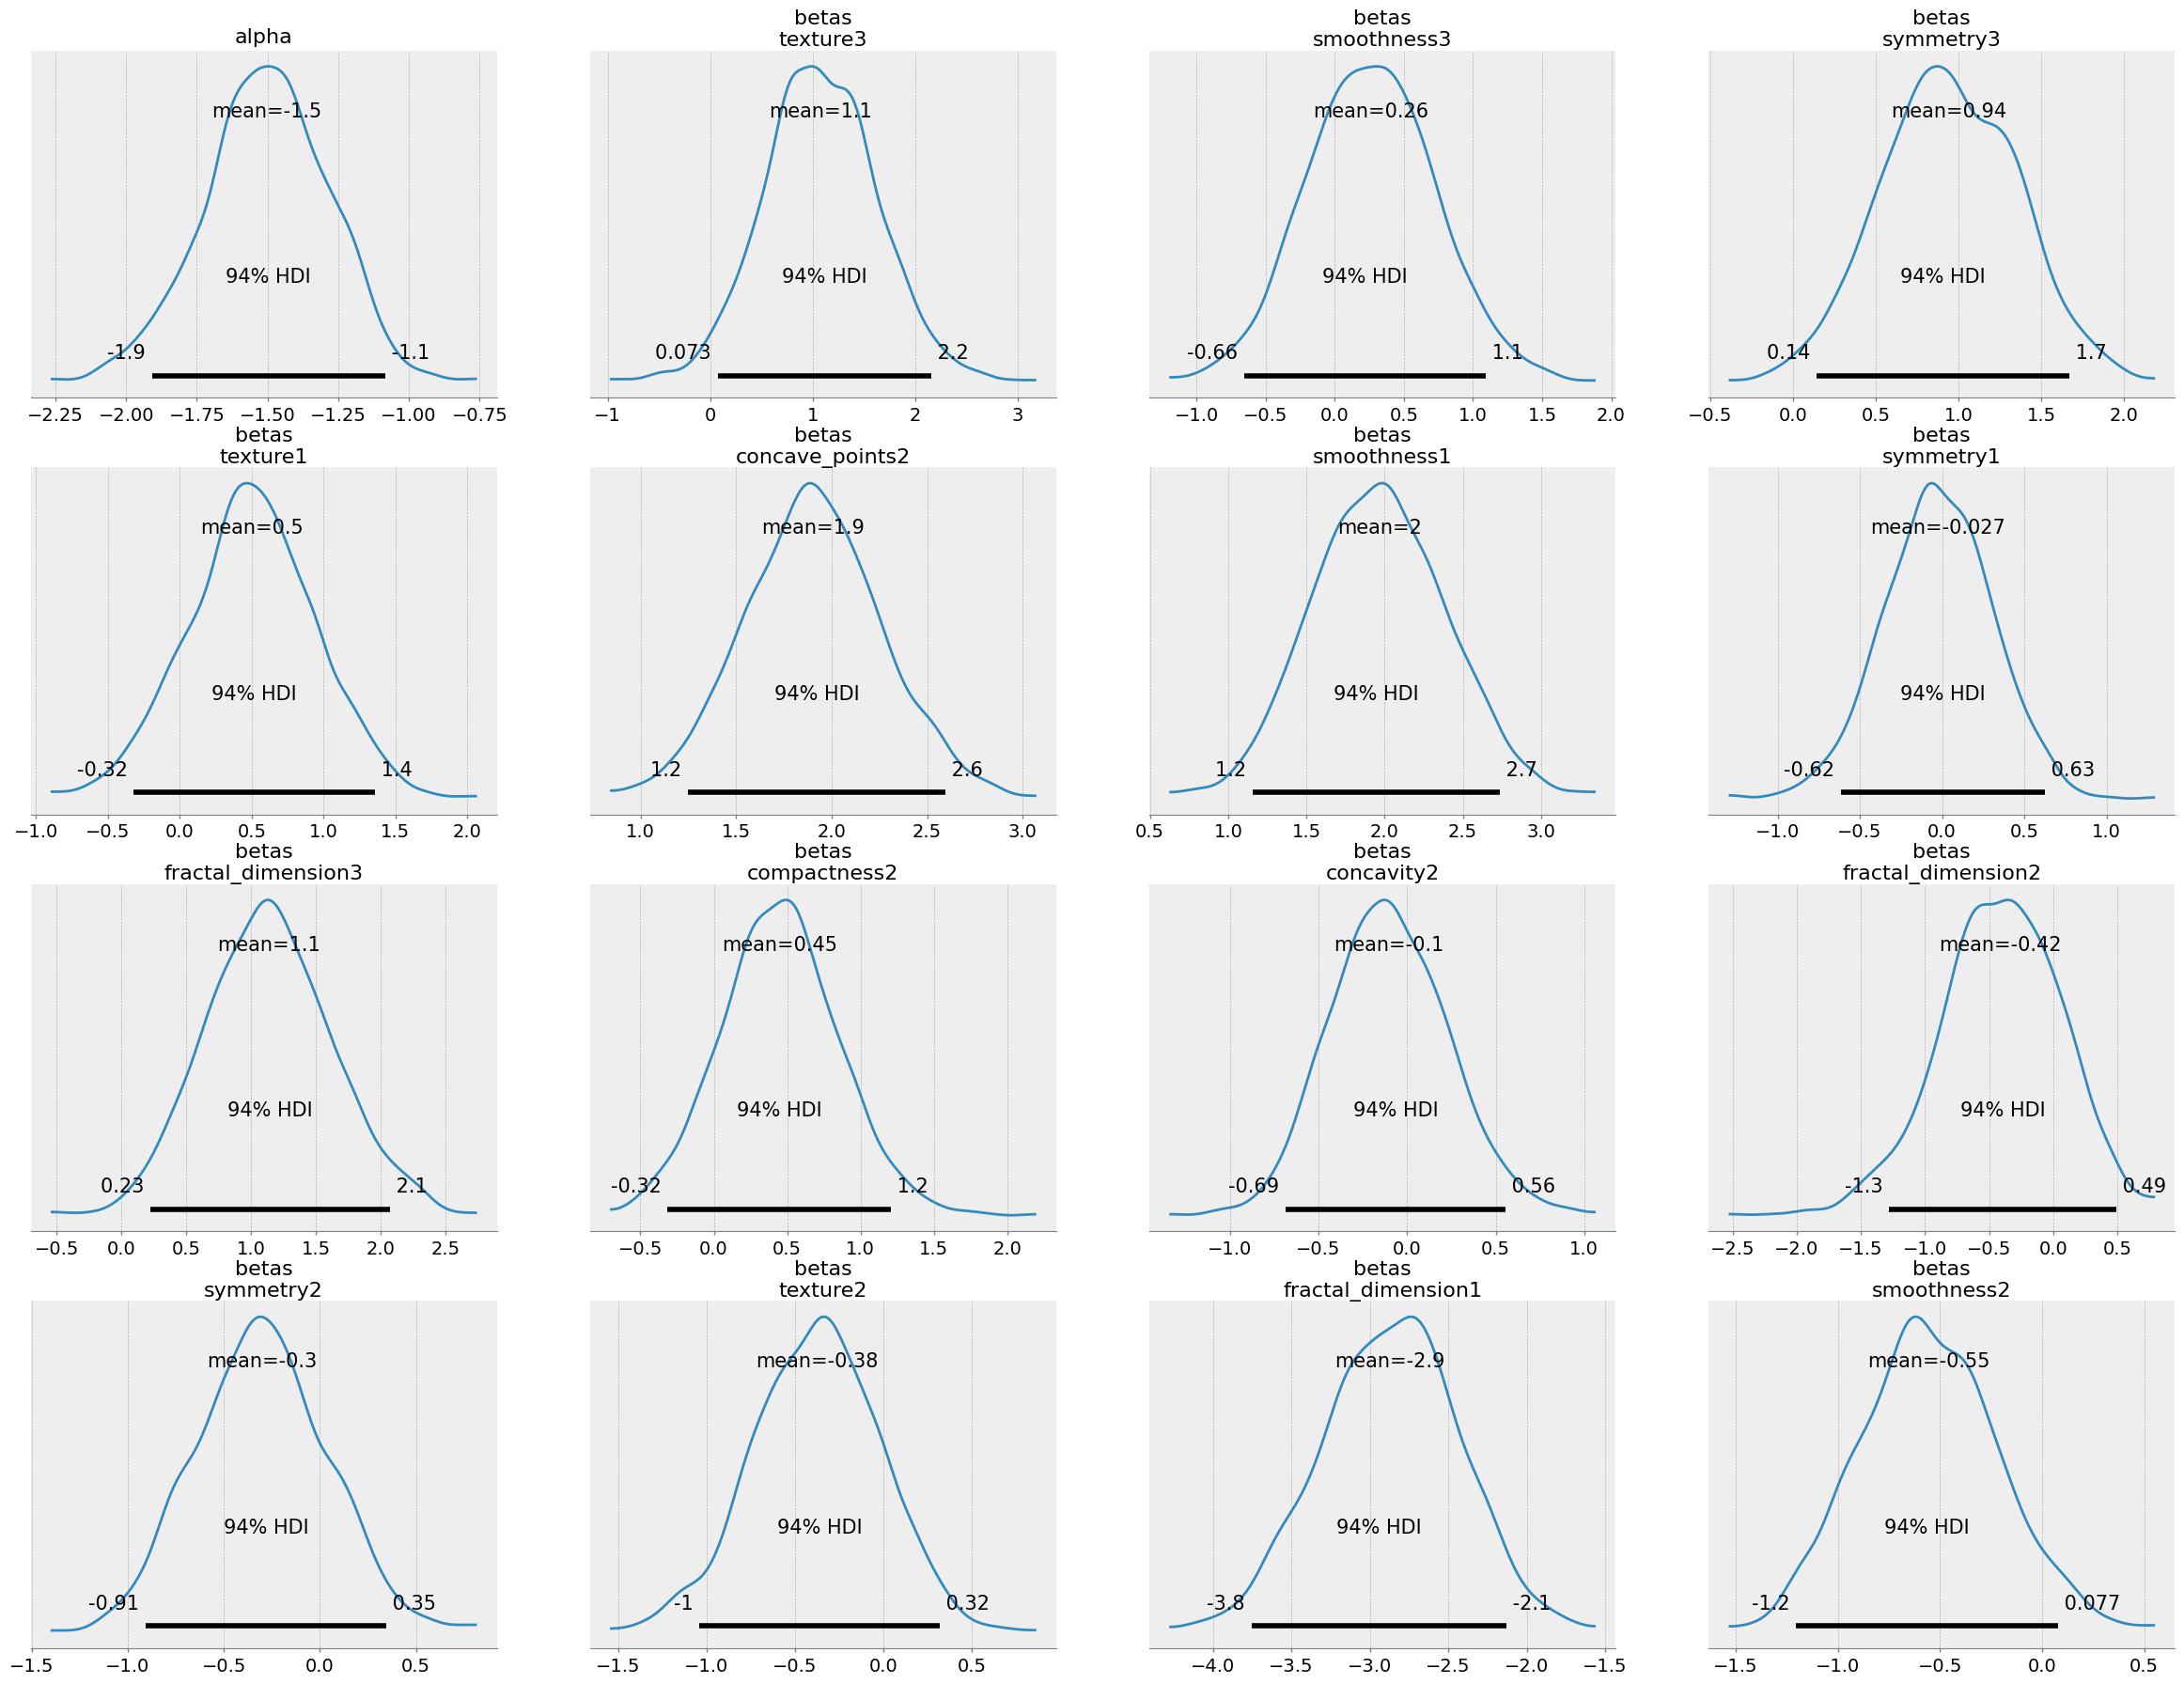

In [67]:
az.plot_trace(trace)
az.plot_posterior(trace, hdi_prob=.94);

### Realizando Teste do Modelo

In [68]:
vars = {'X': X_test.values, 'y': y_test.values}

In [106]:
with logit_model:
  pm.set_data(vars)
  trace_post = pm.sample_posterior_predictive(trace)

mean_likelihood = trace_post.posterior_predictive['likelihood'].mean(dim=['chain', 'draw'])
bin_pred = (mean_likelihood > .5).astype(int)
abs_diff = abs(y_test - bin_pred)

ds = pd.DataFrame({'y_test': y_test, 'predict': bin_pred, 'abs_diff': abs_diff})
ds.T # Aqui eu transposto o dataset para melhorar a visualização dele

Output()

,448,346,568,411,519,527,4,440,479,310,...,88,130,71,60,459,74,39,99,115,219
y_test,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,1,1,0,1
predict,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
abs_diff,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


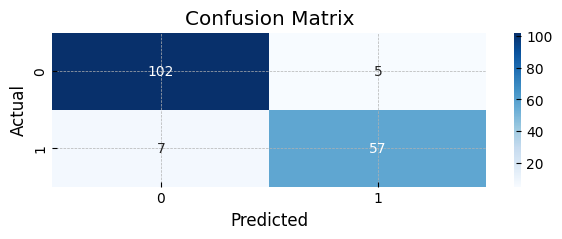

In [107]:
cm = confusion_matrix(ds['y_test'], ds['predict'])
plt.figure(figsize=(7, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [112]:
acc = accuracy_score(y_test, bin_pred)
pre = precision_score(y_test, bin_pred)
rcl = recall_score(y_test, bin_pred)
f1 = f1_score(y_test, bin_pred)

print(f"• Acurácia: {acc:.4f}")
print(f"Precisão: {pre:.4f}")
print(f"Recall: {rcl:.4f}")
print(f"F1 Score: {f1:.4f}")

• Acurácia: 0.9298
Precisão: 0.9194
Recall: 0.8906
F1 Score: 0.9048


## **Conslusão**
> O modelo construido convergiu bem com os dados, e tivemos bons resultados com o conjunto de teste, resultando em uma acurárica de 92%. Em relação a existir poucos caso positivos (considero 1 como positivo), a seleção do conjunto de treino e teste foi estratificado para que a proporção do target fosse o mesmo, por essa razão, consideros que os resultados, possivelmente  não estejam enviasados. Obrigado